In [50]:
# helper
from graphviz import Digraph

def _trace(root):
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)))

    return dot

In [ ]:
import numpy as np
from numbers import Real

def match_shape(grad: np.ndarray, target_shape: tuple) -> np.ndarray:
    # right-align shapes
    gs = grad.shape
    ts = (1,)*(grad.ndim - len(target_shape)) + target_shape

    # build list of axes that must be summed away
    axes = [i for i,(g,t) in enumerate(zip(gs, ts)) if g!=t]
    if axes:
        grad = grad.sum(axis=tuple(axes), keepdims=True)

    return grad.reshape(target_shape)


class Value():
    def __init__(self, data, operation="", children=()):
        if isinstance(data, (list, tuple, Real)):
            data = np.array(data, dtype=float)
        assert isinstance(data, np.ndarray), "data must be a numpy array"
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = np.zeros_like(self.data, dtype=float)
        self._backward = lambda: None

    def __repr__(self):
        return str(self.data)
    
    def dot(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert self.data.ndim == 1 and other.data.ndim == 1, "Dot product is only defined for vectors"
        result = Value(np.dot(self.data, other.data), "•", (self, other))
        def _backward():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result._backward = _backward
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, "+", (self, other))
        def _backward():
            self.grad += match_shape(result.grad, self.data.shape)
            other.grad += match_shape(result.grad, other.data.shape)
        result._backward = _backward
        return result

    def __mul__(self, other): # multiplication is element-wise
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, "*", (self, other))

        def _backward():
            self.grad += match_shape(result.grad * other.data, self.data.shape)
            other.grad += match_shape(result.grad * self.data, other.data.shape)
        result._backward = _backward
        return result
    
    def __matmul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(np.matmul(self.data, other.data), "@", (self, other))
        
        def _backward():
            self_grad = np.matmul(result.grad, other.data.swapaxes(-1, -2))
            other_grad = np.matmul(self.data.swapaxes(-1, -2), result.grad)
            self.grad  += match_shape(self_grad, self.data.shape)
            other.grad += match_shape(other_grad, other.data.shape)
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "power must be float or integer" # must force "other" to be primitive float or int
        result = Value(self.data ** other, "^", (self,))
        def _backward():
            self.grad += match_shape(other * self.data ** (other - 1) * result.grad, self.data.shape)
        result._backward = _backward
        return result
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __rtruediv__(self, other):
        return Value(other) / self
    
    def sum(self, axis=None, keepdims=False):
        result = Value(np.sum(self.data, axis=axis, keepdims=keepdims), "Σ", (self,))
        def _backward():
            factor = result.grad
            if axis is not None and not keepdims:
                factor = np.expand_dims(factor, axis)
            self.grad += match_shape(factor * np.ones_like(self.data), self.data.shape)
        result._backward = _backward
        return result
    
    def backward(self):
        # A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.
        # We need this, since we must call backward() on a child strictly after it has been called on its parent
        nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                nodes.append(v)
        build_topo(self)
        self.grad = np.ones(self.data.shape)
        for node in reversed(nodes):
            node._backward()

    def zero_grad(self):
        visited = set()
        def _zero(v):
            if v not in visited:
                visited.add(v)
                v.grad = np.zeros_like(v.data, dtype=float)
                for child in v.children:
                    assert isinstance(child, Value), "Child must be an instance of Value"
                    _zero(child)
        _zero(self)

    def relu(self):
        result = Value(np.maximum(0, self.data), "ReLU", (self,))
        def _backward():
            self.grad += match_shape((result.data > 0) * result.grad, self.data.shape)
        result._backward = _backward
        return result
    

$$ c = a \times b \quad \text{(element-wise)} $$
$$ c_{ij} = a_{i} b_{j} $$
$$ \frac{\partial c_{ij}}{\partial a_i} = b_j \qquad \frac{\partial c_{ij}}{\partial b_j} = a_i $$
$$ L = \sum_i \sum_j c_{ij} \quad \text{Example scalar loss based on matrix} $$
$$ \frac{\partial L}{\partial a_i} = \sum_j \frac{\partial L}{\partial c_{ij}} \frac{\partial c_{ij}}{\partial a_i} = \sum_j \frac{\partial c_{ij}}{\partial a_i} = \sum_j b_j \qquad \frac{\partial L}{\partial b_j} = \sum_i \frac{\partial L}{\partial c_{ij}} \frac{\partial c_{ij}}{\partial b_j} = \sum_i \frac{\partial c_{ij}}{\partial b_j} = \sum_i a_i $$
<br>

$$
a = \begin{bmatrix} 1 \\ 2 \\ 3 \end{bmatrix} \quad b = \begin{bmatrix} 10 & 20 & 30 \end{bmatrix} \quad c = a @ b = \begin{bmatrix} 1 \\ 2 \\ 3 \end{bmatrix} \begin{bmatrix} 10 & 20 & 30 \end{bmatrix} = \begin{bmatrix} 10 & 20 & 30 \\ 20 & 40 & 60 \\ 30 & 60 & 90 \end{bmatrix}
$$
$$
a = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} \quad b = \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix} \quad c = a @ b = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix} = \begin{bmatrix} a_1 b_1 & a_1 b_2 & a_1 b_3 \\ a_2 b_1 & a_2 b_2 & a_2 b_3 \\ a_3 b_1 & a_3 b_2 & a_3 b_3 \end{bmatrix}
$$
$$
\frac{\partial c}{\partial a_1} = \begin{bmatrix} b_1 & b_2 & b_3 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} \quad
\frac{\partial c}{\partial a_2} = \begin{bmatrix} 0 & 0 & 0 \\ b_1 & b_2 & b_3 \\ 0 & 0 & 0 \end{bmatrix} \quad
\frac{\partial c}{\partial a_3} = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ b_1 & b_2 & b_3 \end{bmatrix}
$$

In [52]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = 0.2 * e

loss.backward()

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

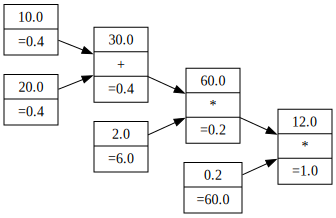

In [53]:
dot = draw_dot(loss)
dot

119.99469589159301 1.0
[ 9.43606798 11.73205081] [6.5 5. ]
[2.23606798 1.73205081] [6.5 5. ]
[5. 3.] [1.45344419 1.44337567]
[6.5 5. ] [ 9.43606798 11.73205081]
[ 7.2 10. ] [6.5 5. ]


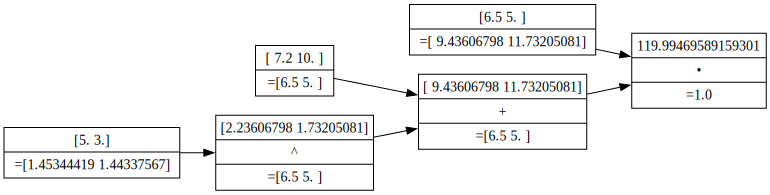

In [54]:
a = Value([5, 3])
b = Value([6.5, 5])
c = Value([7.2, 10])
d = a **0.5
e = d + c
loss = e.dot(b)

loss.backward()

print(loss.data, loss.grad)
print(e.data, e.grad)
print(d.data, d.grad)
print(a.data, a.grad)
print(b.data, b.grad)
print(c.data, c.grad)


dot = draw_dot(loss)
dot

In [ ]:
import random

class Module:
    def zero_grad(self):
        for param in self.parameters():
            param.grad = np.zeros_like(param.data, dtype=float)

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, num_in, nonlin=True):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(num_in)]
        self.bias = Value(0)
        self.nonlin = nonlin
    
    def __call__(self, x):
        x = x.data if isinstance(x, Value) else np.array(x)
        act = sum((wi*xi for wi,xi in zip(self.weights, x)), self.bias)
        return act.relu() if self.nonlin else act
    
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f"Neuron(weights={self.weights}, bias={self.bias}, nonlin={self.nonlin})"

class Layer(Module):
    def __init__(self, num_in, num_out, **kwargs):
        self.neurons = [Neuron(num_in, **kwargs) for _ in range(num_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
    def __repr__(self):
        return f"Layer(neurons={self.neurons})"
    
class MLP(Module):
    def __init__(self, num_in, num_outs):
        sz = [num_in] + num_outs
        self.layers = [Layer(sz[i], sz[i + 1], nonlin=i!=len(num_outs)-1) for i in range(len(num_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __repr__(self):
        return f"MLP(layers={self.layers})"

In [56]:
def MSE(pred, target):
    assert isinstance(pred, Value) and isinstance(target, Value), "Both pred and target must be instances of Value"
    assert pred.data.shape == target.data.shape, "pred and target must have the same shape"
    diff = pred - target
    return (diff ** 2).sum() / 2

In [57]:
model = MLP(2, [3, 1])

x = Value([1, 2])
y = Value(1)

In [58]:
for i in range(200):
    pred = model(x)
    # print(pred)
    loss = (pred - y) ** 2
    print(loss)
    loss.backward()
    for param in model.parameters():
        param.data -= 0.01 * param.grad  # Simple gradient descent step
    model.zero_grad()


1.0
0.9603999999999999
0.9223681600000001
0.885842380864
0.8507630225817856
0.8170728068875469
0.7847167237348001
0.7536419414749018
0.7237977205924958
0.695135330857033
0.6676079717550943
0.6411706960735928
0.6157803365090785
0.5913954351833189
0.5679761759500596
0.5454843193824371
0.5238831403348926
0.5031373679776309
0.48321312820571666
0.4640778883287703
0.445700403950951
0.4280506679544934
0.4110998615034955
0.39482030698795717
0.37918542283123396
0.36416968008711703
0.34974856075566735
0.33589851774974283
0.322596936446853
0.30982209776355757
0.2975531426921208
0.28577003824151276
0.2744535447271489
0.2635851843559538
0.25314721105545807
0.24312258149766183
0.23349492727035442
0.22424852815044838
0.2153682864356906
0.20683970229283727
0.19864885008204092
0.19078235561879212
0.183227374336288
0.17597157031257096
0.1690030961281932
0.1623105735215168
0.1558830748100647
0.1497101050475861
0.14378158488770174
0.13808783412614872
0.13261955589475324
0.127367821481321
0.122324055750660